# Variable dz water balance

Comparing het1 and het2, different scenarios, 1 year of simulation post-spinup

In [1]:
from postproc import scale_pfb
import numpy as np

import subprocess
import glob
import os
import shutil
import time
import pandas as pd
from io import StringIO

import itertools


%matplotlib inline

In [2]:
cur_stop = 87610

In [3]:
rundir = '/home/theo/pf_files/pf_machine/scenarios/het2/01run'
#rundir = '/home/tclim/Dropbox/projects/pf_simple/01testruns/constslope/'

## Write Silo Files for Water Balance

In [4]:
bashCommand = "tclsh write_wb_silos.tcl %s %s %s %s" %(rundir,'slopes_only',0,cur_stop)
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
print(output)
print(error)

b''
None


## Read in NLDAS input

```
DSWR: Downward Visible or Short-Wave radiation [W/m2 ]. (SW radiation flux downwards)
DLWR: Downward Infa-Red or Long-Wave radiation [W/m2 ] (LW radiation flux downwards)
APCP: Precipitation rate [mm/s]  (Precipitation hourly total)
Temp: Air temperature [K]  (2-m above ground Termperature)
UGRD: West-to-East or U-component of wind [m/s]  (10-m above ground Zonal wind speed)
VGRD: South-to-North or V-component of wind [m/s] (10-m above ground Medional wind speed)
Press: Atmospheric Pressure [pa] (Surface Pressure)
SPFH: Water-vapor specific humidity [kg/kg] (2-m above ground humidity)

```

In [5]:
nldas = pd.read_fwf('%s/dauphco.nldas.10yr.txt' %rundir, header = None, sep = '')
nldas.columns = ['DSWR', 'DLWR', 'APCP', 'TMP', 'UGRD', 'VGRD', 'PRESS', 'SPFH']
nldas.head()

,DSWR,DLWR,APCP,TMP,UGRD,VGRD,PRESS,SPFH
0,0.0,306.959991,0.000212,270.720001,-0.66,1.46,98751.226562,0.003161
1,0.0,306.959991,0.000166,270.950012,-0.51,1.10,98789.796875,0.003190
2,0.0,306.959991,0.000200,271.179993,-0.37,0.73,98827.718750,0.003218
3,0.0,306.019989,0.000065,271.410004,-0.22,0.36,98866.281250,0.003247
4,0.0,306.019989,0.000049,271.309998,-0.24,0.18,98764.718750,0.003246


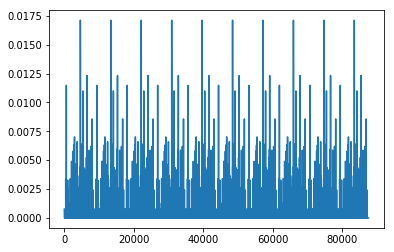

In [6]:
prcp_m_hr = nldas.APCP/1000*60*60 # meters per hour precipitation
prcp_v = prcp_m_hr*1200*1000 # total precip volume over domain (to use in water balance)

prcp_m_hr[:cur_stop].plot.line()

In [7]:
lst = range(1,366)
d = list(itertools.chain.from_iterable(itertools.repeat(x, 24) for x in lst))
d.append(366)
len(d)

8761

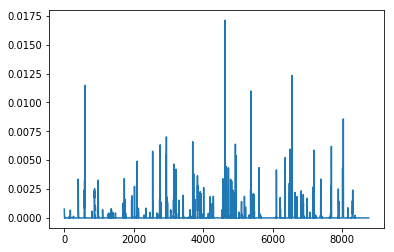

In [8]:
prcp_1yr = pd.DataFrame({'prcp_m_h' : prcp_m_hr[:8761],
                        'doy': d})
prcp_1yr['prcp_m_h'].plot.line()

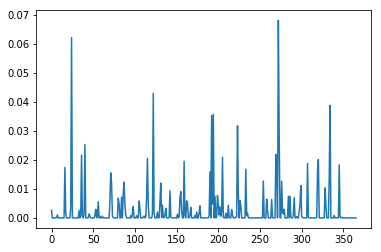

In [9]:
# DAILY PRECIPITATION TOTALS
prcp_1yr_daily = prcp_1yr.groupby(['doy'], as_index=False).sum()
prcp_1yr_daily['prcp_m_h'].plot.line()

In [10]:
def silo2pfb(rundir, bnam, start, stop, fw=0):
    '''
    Converts a timeseries of silo output to pfb format
    (saves converted pfbs to same directory)
    
    bnam     the basename of the files (everything up to the iterating index)
    start    start number of file indexing
    end      end number of file indexing
    fw       fixed width = 0 for non-fixed width iterating index, 
             fixed width = 1 for fixed width (assumed width is 5) index.
    '''
    bashCommand = "tclsh silotopfb_iter_bnam.tcl %s %s %s %s %s" %(rundir, bnam,start,stop, fw)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    print(output)
    print(error)
    
    # if fw =1, rename the output files to remove $runname.out
    if fw:
        print("renaming output pfb files")
        newbnam = bnam.split(".")[-1]
        
        for i in range(start, stop+1):
            ofnam = "%s/%s.%s.pfb" %(rundir,bnam,i)
            nfnam = "%s/%s.%s.pfb" %(rundir,newbnam,i)
            os.rename(ofnam, nfnam)

def sumoverdomain(rundir, bnam, start, stop):
    '''
    Sums over the entire domain for an input pfb file,
    returns a dataframe with columns for t and the sum values
    
    bnam    the base name of the files to sum
    start   the start number of file indexing
    end     the end number of file indexing
    '''
    bashCommand = "tclsh sum_domain_bnam.tcl %s %s %s %s" %(rundir, bnam,start,stop)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

    # Save the output to a dataframe
    output = output.decode("utf-8").format()
    df = pd.read_csv(StringIO(output), sep="\t", header = None)
    df.columns = ['t','sum_val']  # add a header (column name)
    
    # return
    return(df)
    

# Apply scale factors for vdz

The scaling factors need to be applied for subsurface storage, and potentially to surface storage and surface runoff as well.

- Need a silotopfb_iter.tcl script that can be applied to various files' base names

In [11]:
factors = np.array([[2.0],  # <- bottom
                    [2.0],
                    [2.0],
                    [1.0],
                    [1.0],
                    [1.0],
                    [0.25],
                    [0.25],
                    [0.25],
                    [0.25]]) # <- top

## Overland Flow 
Overland flow does not need scale factors applied.

**NOTE**: Overland flow needs to be calculated from the silo files that are output from having the Key `pfset Solver.WriteSiloOverlandSum` on. This will produce the correct overland flow sums from the domain needed to close the water balance. The files are of the form: `<runname>.out.overlandsum.00001.silo`. 

In [12]:
silo2pfb(rundir = rundir, 
         bnam ='slopes_only.out.overlandsum' , start= 1, stop=cur_stop, fw = 1)

of = sumoverdomain(rundir = rundir, 
                   bnam = 'overlandsum',start = 1, stop= cur_stop)
of['sum_val'] = of['sum_val']
of.head(10)

b''
None
renaming output pfb files


,t,sum_val
0,1,26.562120
1,2,26.446897
2,3,26.345665
3,4,26.239331
4,5,26.138701
5,6,26.041038
6,7,25.948319
7,8,25.860313
8,9,25.777960
9,10,25.701096


## Surface Storage 
Surface storage does not need scale factors applied

In [13]:
silo2pfb(rundir = rundir, bnam ='surface_storage' , start= 0, stop=cur_stop)
s = sumoverdomain(rundir = rundir, bnam = 'surface_storage',start = 0, stop= cur_stop)
s.head(10)

b''
None


,t,sum_val
0,0,63804.898853
1,1,64117.158826
2,2,64368.946807
3,3,64646.414541
4,4,64825.813307
5,5,64991.366296
6,6,65130.295493
7,7,65259.000867
8,8,65389.561740
9,9,65520.148948


## Subsurface storage

In [15]:
# convert silos to pfbs
silo2pfb(rundir = rundir, bnam ='subsurface_storage' , start= 0, stop=cur_stop)

# scale pfbs using factors
for i in range(0,cur_stop+1):
    infnam = '%s/subsurface_storage.%s.pfb' %(rundir, i)
    outfnam = '%s/vdz_subsurface_storage.%s.pfb' %(rundir,i)
    
    scale_pfb(pfbinfnam = infnam, vdzarr = factors, pfboutfnam = outfnam, 
         nx = 12, ny = 10, dx = 10, dy = 10, dz = 1)
    
ss = sumoverdomain(rundir = rundir,
                   bnam = 'vdz_subsurface_storage',start = 0, stop= cur_stop)
ss.head(10)

b''
None


,t,sum_val
0,0,3.159146e+06
1,1,3.159468e+06
2,2,3.159712e+06
3,3,3.160044e+06
4,4,3.160035e+06
5,5,3.159989e+06
6,6,3.159853e+06
7,7,3.159686e+06
8,8,3.159518e+06
9,9,3.159350e+06


## Evapotranspiration

In [17]:
factors = np.array([[2.0],  # <- bottom
                    [2.0],
                    [2.0],
                    [1.0],
                    [1.0],
                    [1.0],
                    [0.25],
                    [0.25],
                    [0.25],
                    [0.25]]) # <- top

silo2pfb(rundir = rundir, 
         bnam ='slopes_only.out.evaptranssum' , start= 1, stop=cur_stop, fw = 1)

# scale pfbs using factors
for i in range(1,cur_stop):
    infnam = '%s/evaptranssum.%s.pfb' %(rundir, i)
    outfnam = '%s/vdz_evaptranssum.%s.pfb' %(rundir,i)
    
    scale_pfb(pfbinfnam = infnam, vdzarr = factors, pfboutfnam = outfnam, 
         nx = 12, ny = 10, dx = 10, dy = 10, dz = 1)

et = sumoverdomain(rundir = rundir, 
                   bnam = 'vdz_evaptranssum',start = 1, stop= cur_stop)
et['sum_val'] = et['sum_val']
et['t'] = et['t'] - 1
et.head(10)

b''
None
renaming output pfb files


,t,sum_val
0,0,660.670360
1,1,522.178647
2,2,636.215510
3,3,196.890156
4,4,145.339729
5,5,29.153949
6,6,-12.524103
7,7,-11.776546
8,8,-11.355452
9,9,-10.976360


In [18]:
et.tail()

,t,sum_val
87604,87604,74.791131
87605,87605,75.046611
87606,87606,75.315060
87607,87607,75.597147
87608,87608,75.893449


# Water balance

**NOTE** This will not balance if the run was executed with overland flow keys on! Water will begin to be "lost" from the domain when overland flow occurs.

In [19]:
wb = ss.merge(of, on = 't', how = 'left').merge(s, on = 't', how = 'left').merge(et, on = 't', how = 'left')
wb.columns = ['t', 'vdz_subsurfstor', 'overland_flow', 'surf_stor', 'vdz_et']
wb['overland_flow'] = (- wb['overland_flow'])  
wb['overland_flow'] = wb['overland_flow'].shift(-1)  
wb['dom_tot'] = wb['vdz_subsurfstor'] +  wb['surf_stor'] 
wb['bndy_flux'] = wb['vdz_et'] + wb['overland_flow']                
wb['exp_wb'] = wb['dom_tot'].shift(-1) + wb['bndy_flux']
wb['dom_tot_chg'] = wb['dom_tot'].diff()
wb['dom_tot_chg'] = wb['dom_tot_chg'].shift(-1)
wb['diff'] = wb['dom_tot_chg'] - wb['bndy_flux']
wb['pc_diff'] = abs(wb['diff'])/wb['exp_wb']*100
wb['prcp_v'] = prcp_v[:cur_stop]

wb.head(20)

,t,vdz_subsurfstor,overland_flow,surf_stor,vdz_et,dom_tot,bndy_flux,exp_wb,dom_tot_chg,diff,pc_diff,prcp_v
0,0,3.159146e+06,-26.562120,63804.898853,660.670360,3.222951e+06,634.108240,3.224219e+06,634.108241,5.307536e-07,1.646146e-11,914.4144
1,1,3.159468e+06,-26.446897,64117.158826,522.178647,3.223585e+06,495.731750,3.224576e+06,495.731749,-2.181704e-07,6.765863e-12,717.5952
2,2,3.159712e+06,-26.345665,64368.946807,636.215510,3.224081e+06,609.869845,3.225300e+06,609.869852,6.360345e-06,1.972016e-10,862.7904
3,3,3.160044e+06,-26.239331,64646.414541,196.890156,3.224691e+06,170.650825,3.225032e+06,170.650847,2.187403e-05,6.782577e-10,281.5344
4,4,3.160035e+06,-26.138701,64825.813307,145.339729,3.224861e+06,119.201029,3.225100e+06,119.201035,5.704544e-06,1.768796e-10,210.9456
5,5,3.159989e+06,-26.041038,64991.366296,29.153949,3.224980e+06,3.112911,3.224987e+06,3.112905,-5.146995e-06,1.595974e-10,56.4192
6,6,3.159853e+06,-25.948319,65130.295493,-12.524103,3.224984e+06,-38.472422,3.224907e+06,-38.472420,1.587532e-06,4.922722e-11,0.0000
7,7,3.159686e+06,-25.860313,65259.000867,-11.776546,3.224945e+06,-37.636859,3.224870e+06,-37.636870,-1.144680e-05,3.549540e-10,0.0000
8,8,3.159518e+06,-25.777960,65389.561740,-11.355452,3.224907e+06,-37.133413,3.224833e+06,-37.133413,-4.111488e-07,1.274946e-11,0.0000
9,9,3.159350e+06,-25.701096,65520.148948,-10.976360,3.224870e+06,-36.677456,3.224797e+06,-36.677463,-6.715266e-06,2.082384e-10,0.0000


In [20]:
wb[abs(wb['pc_diff']) > 0.0005].shape  # this should have zero rows if the water balance is closing

(0, 12)

In [21]:
# check what the pct differences are
max(wb.pc_diff.dropna())

9.354597284594439e-08

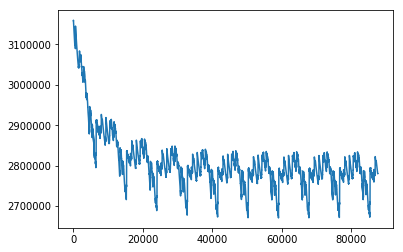

In [22]:
wb['vdz_subsurfstor'].plot.line()

In [32]:
wb['vdz_subsurfstor'][np.multiply(8610, [0,1,2,3,4,5,6,7,8,9,10])].pct_change()

0             NaN
8610    -0.085372
17220   -0.017244
25830   -0.003876
34440   -0.003719
43050   -0.011409
51660   -0.003519
60270    0.004188
68880   -0.007755
77490    0.004721
86100   -0.001602
Name: vdz_subsurfstor, dtype: float64

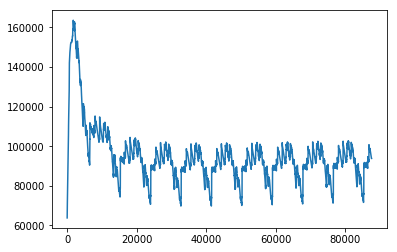

In [23]:
wb['surf_stor'].plot.line()

In [33]:
wb['surf_stor'][np.multiply(8610, [0,1,2,3,4,5,6,7,8,9,10])].pct_change()

0             NaN
8610     0.701234
17220   -0.089283
25830   -0.011431
34440   -0.009484
43050   -0.047938
51660   -0.018130
60270    0.020155
68880   -0.034881
77490    0.022801
86100   -0.007084
Name: surf_stor, dtype: float64

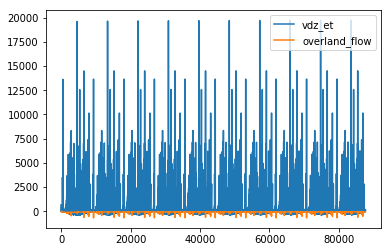

In [24]:
# boundary fluxes
wb[['vdz_et', 'overland_flow']].plot.line()

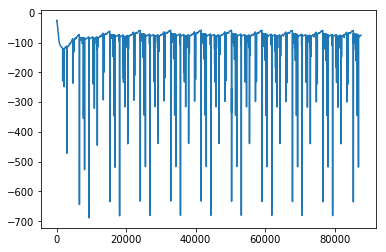

In [25]:
wb['overland_flow'].plot()

In [26]:
wb['overland_flow'].describe()

count    87610.000000
mean       -77.752181
std         22.667518
min       -689.100031
25%        -78.459488
50%        -74.637859
75%        -70.970173
max        -25.026235
Name: overland_flow, dtype: float64

In [27]:
wb['overland_flow'].median()

-74.63785930061778

In [28]:
# save this water balance to file
wb.to_csv('het2_10yr.csv')